In [ ]:
import pandas as pd
import csv as csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv("train.csv").replace("male", 0).replace("female", 1)
df["Age"].head()
#欠損処理 by median
df["Age"].fillna(df.Age.median(), inplace = True)
df["Age"].head()
df["FamiliySize"] = df["SibSp"] + df["Parch"] + 1 #Familiysizeを親族＋子供の数＋本人で算出。同部屋の可能性などを探る。
df_dropped = df.drop(["Name", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked", "PassengerId"], axis = 1)#関係ない奴、Familysizeに統合された奴は省いたDf作成。
df_dropped.head()

In [28]:
#LogRegに引き続いて説明変数を二つ選んで格納していく。
#Sex and Pclassが高そうだから選ぶ
#今回はなぜか分からんがArray型に変換。DataFrameじゃ処理ができないっぽい。
x = df_dropped.loc[:,["Sex", "Pclass"]].values
y = df_dropped.loc[:,["Survived"]].values #Survivedの被説明変数を格納

# scikit-learnの仕様に合わせて､一列のベクトルに変換
y = y.reshape(-1)

# データの標準化、分類系では基本標準化した方が良い
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)
x_std = scaler.transform(x)
x_std

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-0.73769513,  0.82737724],
       [ 1.35557354, -1.56610693],
       [ 1.35557354,  0.82737724],
       ..., 
       [ 1.35557354,  0.82737724],
       [-0.73769513, -1.56610693],
       [-0.73769513,  0.82737724]])

In [38]:
#データ分割から学習へ
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_std, y, test_size=0.3, random_state=0)
# 線形SVCの学習
from sklearn.svm import SVC
svc = SVC(kernel='linear', C = 10)
svc.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [39]:
# 正答率を出力
svc.score(X_test, y_test)

0.78731343283582089

In [44]:
#結果があんま変わらんので混合行列で見てみる。
from sklearn.metrics import confusion_matrix
cm_1 = confusion_matrix(y_test, svc.predict(X_test))
cm_1
# 混合行列をグラフでプロットする関数
def plot_cm(confmat):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.title('predicted label')
    plt.ylabel('true label')
    plt.tight_layout() # ラベルが重ならないように自動調整
    plt.show()

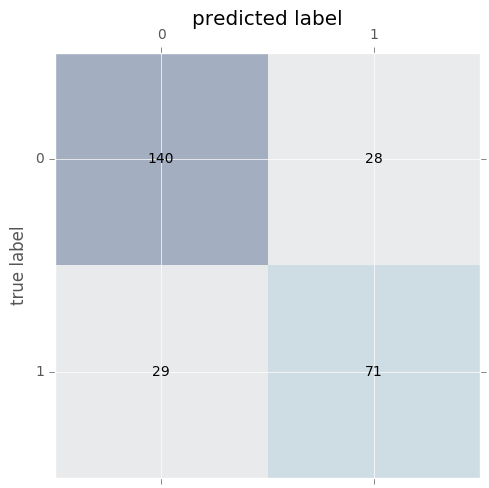

In [45]:
# 混同行列をグラフでプロット、別にそんなに傾向はみられない。
plot_cm(cm_1)

In [46]:
#テストデータも同じ処理をしてreal_testを作成
df_test = pd.read_csv("test.csv").replace("male", 0).replace("female", 1)
x_real_test = df_test.loc[:,["Sex", "Pclass"]]

# データの標準化、分類系では基本標準化した方が良い
scaler.fit(x_real_test)
x_test_std = scaler.transform(x_real_test)

#モデルにX_test_std入れて予測
output = svc.predict(x_test_std)

#予測結果とPassIDをZipする
zip_data = zip(df_test["PassengerId"].astype(int), output.astype(int))
predict_data = list(zip_data)

# テスト値を再読み込みして，rfでクラス分類したカラムを追加
df_out = pd.read_csv("./test.csv")
df_out["Survived"] = output

# outputディレクトリに出力する
df_out[["PassengerId","Survived"]].to_csv("./submission_svc.csv",index=False)